<div align="right" style="text-align: right"><i>Peter Norvig<br>March 2018</i></div> 

# Maze Generation

Let's make some mazes! I'm thinking of mazes like this one, which is  a rectangular grid of squares, with walls on some of the sides of squares, and openings on other sides. The goal is to get from the red arrow to the green arrow.

![Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Maze_simple.svg/475px-Maze_simple.svg.png)

The two main constraints are that there should be a path from entrance to exit, and it should be ***fun*** to solve the maze with pencil, paper, and brain power&mdash;not too easy, but also not impossible.  

As I think about how to model a maze on the computer, it seems like a **graph** is the right model: the nodes of
the graph are the squares of the grid, and the edges of the graph are the openings between adjacent squares. So what properties of a graph make a good maze?
- There must be a path from entrance to exit.
- There must not be too many such paths; maybe it is best if there is only one. 
- Probably the graph should be *singly connected*&mdash;there shouldn't be islands of squares that are unreachable from the start. In fact, maybe we want exactly one path between any two squares.
- The path should have many twists; it would be too easy if it was mostly straight.

I know that a **tree** has all these properties except the last one. So my goal has become: *Superimpose a tree over the grid, covering every square, and make sure the paths are twisty.* Here's how I'll do it:

- Start with a grid with no edges (every square is surrounded by walls on all sides). 
- Add edges (that is, knock down walls) for the entrance at upper left and exit at lower right.
- Place the root of the tree in some square.
- Then repeat until the tree covers the whole grid:
  * Select some node already in the tree.
  * Randomly select a neighbor that hasn't been added to the tree yet.
  * Add an edge (knock down the wall) from the node to the neighbor.
  
In the example below, the root, `A`, has been placed in the upper-left corner, and  two branches,
`A-B-C-D` and `A-b-c-d`, have been randomly chosen (well, not actually random; they are starting to create the same maze as in the diagram above):

     o  o--o--o--o--o--o--o--o--o--o
     | A  b  c|  |  |  |  |  |  |  |
     o  o--o  o--o--o--o--o--o--o--o
     | B|  | d|  |  |  |  |  |  |  |
     o  o--o--o--o--o--o--o--o--o--o
     | C  D|  |  |  |  |  |  |  |  |
     o--o--o--o--o--o--o--o--o--o--o
     |  |  |  |  |  |  |  |  |  |  |
     o--o--o--o--o--o--o--o--o--o--o
     |  |  |  |  |  |  |  |  |  |  |
     o--o--o--o--o--o--o--o--o--o  o
    
Next I select node `d` and extend it to `e` (at which point there are no available neighbors, so `e` will not be selected in the future), and then I select `D` and extend from there all the way to `N`, at each step selecting the node I just added:

     o  o--o--o--o--o--o--o--o--o--o
     | A  b  c|  |  |  |  |  |  |  |
     o  o--o  o--o--o--o--o--o--o--o
     | B| e| d|  | N|  |  |  |  |  |
     o  o--o--o--o  o--o--o--o--o--o
     | C  D|  |  | M|  |  |  |  |  |
     o--o  o--o--o  o--o--o--o--o--o
     | F  E|  | K  L|  |  |  |  |  |
     o  o--o--o  o--o--o--o--o--o--o
     | G  H  I  J|  |  |  |  |  |  |
     o--o--o--o--o--o--o--o--o--o  o
     
Continue like this until every square in the grid has been added to the tree. 


# Implementing Random Trees

I'll make the following implementation choices:

- A tree will be represented as a list of edges.
- An `Edge` is a tuple of two nodes. Edges are bidirectional, so to avoid confusion we will always us the tuple that is in sorted order: always `(1, 2)`, never `(2, 1)`. The constructor `edge` enforces that.
- A node in a tree can be anything: a number, a letter, a square, ...
- The algorithm for `random_tree(nodes, neighbors, pop)` works as follows:
  * The arguments are:
    - `nodes`: a collection of nodes.
    - `neighbors`: a function such that `neighbors(node)` returns a set of nodes.
    - `pop`: a function such that `pop(frontier)` removes and returns an element from `frontier`.
  * The function keeps track of three collections:
    - `tree`: a list of edges that constitutes the tree.
    - `nodes`: the set of nodes that have not yet been added to the tree, but will be.
    - `frontier`: a queue of nodes in the tree that are eligible to have an edge added.
  * On each iteration:
    - Use `pop` to pick a `node` from the frontier, and find the neighbors that are not already in the tree.
    - If there are any neighbors, randomly pick one (`nbr`), add `edge(node, nbr)` to `tree`, remove the
      neighbor from `nodes`, and keep both the node and the neighbor on the frontier. If there are no neighbors,
      drop the node from the frontier.
  * When no `nodes` remain, return `tree`.

In [1]:
import random
from collections import deque, namedtuple

Edge = tuple
Tree = list

def edge(A, B) -> Edge: return Edge(sorted([A, B]))

def random_tree(nodes, neighbors, pop=deque.pop) -> [Edge]:
    """Repeat: pop a node and add edge(node, nbr) until all nodes have been added to tree."""
    tree = Tree()
    nodes = set(nodes)
    root = nodes.pop()
    frontier = deque([root])
    while nodes:
        node = pop(frontier)
        nbrs = neighbors(node) & nodes
        if nbrs:
            nbr = random.choice(list(nbrs))
            tree.append(edge(node, nbr))
            nodes.remove(nbr)
            frontier.extend([node, nbr])
    return tree

# Implementing  Random Mazes

Now let's use `random_tree` to implement `random_maze`.  Some more choices:

* A `Maze` is a named tuple with three fields: the `width` and `height` of the grid, and a list of  `edges` between squares. 
* A square is denoted by an `(x, y)` tuple of integer coordinates.
* The function `neighbors4` gives the four surrounding squares.

In [2]:
Maze = namedtuple('Maze', 'width, height, edges')

Square = tuple

def neighbors4(square) -> {Square}:
    """The 4 neighbors of an (x, y) square."""
    (x, y) = square
    return {(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)}

def squares(width, height) -> {Square}: 
    """All squares in a grid of these dimensions."""
    return {(x, y) for x in range(width) for y in range(height)}

def random_maze(width, height, pop=deque.pop) -> Maze:
    """Generate a random maze, using rrandom_tree."""
    nodes = squares(width, height)
    tree = random_tree(nodes, neighbors4, pop)
    return Maze(width, height, tree)

In [3]:
random_maze(10,5)

Maze(width=10, height=5, edges=[((6, 3), (7, 3)), ((6, 3), (6, 4)), ((5, 4), (6, 4)), ((4, 4), (5, 4)), ((4, 3), (4, 4)), ((3, 3), (4, 3)), ((2, 3), (3, 3)), ((1, 3), (2, 3)), ((0, 3), (1, 3)), ((0, 2), (0, 3)), ((0, 1), (0, 2)), ((0, 0), (0, 1)), ((0, 0), (1, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((2, 1), (3, 1)), ((3, 1), (3, 2)), ((2, 2), (3, 2)), ((1, 2), (2, 2)), ((3, 2), (4, 2)), ((4, 2), (5, 2)), ((5, 2), (5, 3)), ((5, 2), (6, 2)), ((6, 2), (7, 2)), ((7, 1), (7, 2)), ((6, 1), (7, 1)), ((5, 1), (6, 1)), ((4, 1), (5, 1)), ((4, 0), (4, 1)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((6, 0), (7, 0)), ((7, 0), (8, 0)), ((8, 0), (9, 0)), ((9, 0), (9, 1)), ((9, 1), (9, 2)), ((9, 2), (9, 3)), ((9, 3), (9, 4)), ((8, 4), (9, 4)), ((8, 3), (8, 4)), ((8, 2), (8, 3)), ((8, 1), (8, 2)), ((7, 4), (8, 4)), ((3, 0), (4, 0)), ((2, 0), (3, 0)), ((0, 3), (0, 4)), ((0, 4), (1, 4)), ((1, 4), (2, 4)), ((2, 4), (3, 4))])

That's not very pretty to look at. I'm going to need a way to visualize a maze.

# Printing a maze

Here's a function to print a maze:

In [4]:
def print_maze(maze, dot='o', bar='|', sp1=' ', sp2='  ', lin='--'):
    """Print maze in ASCII."""
    exit = edge((maze.width-1, maze.height-1), (maze.width-1, maze.height))
    edges = set(maze.edges) | {exit}
    print(dot + sp2 + lin.join(dot * maze.width)) # Top line, including entrance
    def vert_wall(x, y): return (sp1 if edge((x, y), (x+1, y)) in edges else bar)
    def horz_wall(x, y): return (sp2  if edge((x, y), (x, y+1)) in edges else lin)
    for y in range(maze.height):
        print(bar + cat(sp2 + vert_wall(x, y) for x in range(maze.width)))
        print(dot + cat(horz_wall(x, y) + dot for x in range(maze.width)))
        
cat = ''.join
        
print_maze(random_maze(10, 5))

o  o--o--o--o--o--o--o--o--o--o
|           |        |        |
o--o--o--o  o  o--o  o  o--o  o
|     |     |     |  |     |  |
o  o  o  o--o--o  o  o--o  o  o
|  |     |        |        |  |
o  o--o  o  o--o--o--o--o--o  o
|     |  |        |  |  |     |
o  o  o--o--o--o  o  o  o  o  o
|  |                 |     |  |
o--o--o--o--o--o--o--o--o--o  o


*Much better!* But can I do better still?

# Plotting a maze

I'll use `matplotlib` to plot lines where the edges aren't:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_maze(maze, figsize=None):
    """Plot a maze by drawing lines between adjacent squares, except for pairs in maze.edges"""
    w, h  = maze.width, maze.height
    plt.figure(figsize=figsize or (w/5, h/5))
    plt.axis('off')
    plt.gca().invert_yaxis()
    exits = {edge((0, 0), (0, -1)), edge((w-1, h-1), (w-1, h))}
    edges = set(maze.edges) | exits
    for sq in squares(w, h):
        for nbr in neighbors4(sq):
            if edge(sq, nbr) not in edges:
                plot_wall(sq, nbr)
    plt.show()

def plot_wall(s1, s2):
    """Plot a thick black line between squares s1 and s2."""
    (x1, y1), (x2, y2) = s1, s2
    if x1 == x2: # horizontal wall
        y = max(y1, y2)
        X, Y = [x1, x1+1], [y, y]
    else: # vertical wall
        x = max(x1, x2)
        X, Y = [x, x], [y1, y1+1]
    plt.plot(X, Y, 'k-', linewidth=3.0)

Let's compare the two visualization functions:

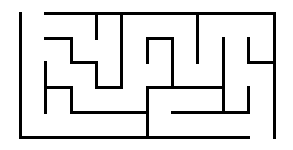

o  o--o--o--o--o--o--o--o--o--o
|        |  |        |        |
o  o--o  o  o  o--o  o  o  o  o
|     |     |  |  |  |  |  |  |
o  o  o--o  o  o  o  o  o  o--o
|  |     |  |     |     |     |
o  o--o  o--o  o--o--o--o  o  o
|  |  |        |        |  |  |
o  o  o--o--o--o  o--o--o--o  o
|              |              |
o--o--o--o--o--o--o--o--o--o  o


In [6]:
M = random_maze(10, 5)

plot_maze(M, (5, 2.5))  
print_maze(M)

# `pop` strategies

Now I want to compare how the maze varies based on theree different choices for the `pop` parameter. 

# `deque.pop`

The default pop method means that the tree is created **depth-first**; we always select the `node` at the end of the `frontier`, so the tree follows a single branch along a randomly-twisted path until the path doubles back on itself and there are no more neighbors; at that point we select the most recent square for which there are neighbors. The maze with `deque.pop` looks pretty good. Reminds me of those [cyber brain](https://www.vectorstock.com/royalty-free-vector/cyber-brain-vector-3071965) images:

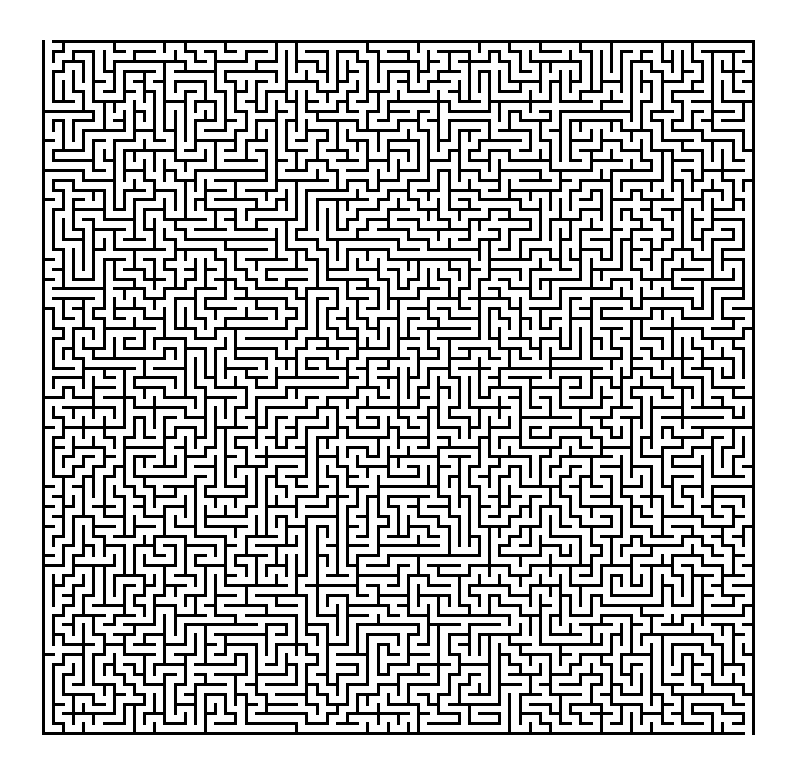

In [13]:
plot_maze(random_maze(70, 70, deque.pop))

# `deque.popleft`

This creates the maze roughly **breadth-first**&mdash;we start at some root square , add an edge to it, and from then on we always select first a parent edge before we select a child edge. The net result is a design that appears to radiate out in concentric layers from the root (which is chosen by `random_tree` and is not necessarily the top-left square; below it looks like the root is in the lower-right quadrant). The `deque.popleft` maze is interesting as a design, but to me it doesn't work well as a maze. It is too easy to say: follow the path from the start to the center point, then consider the path from the end to the center point, and see how they match up.

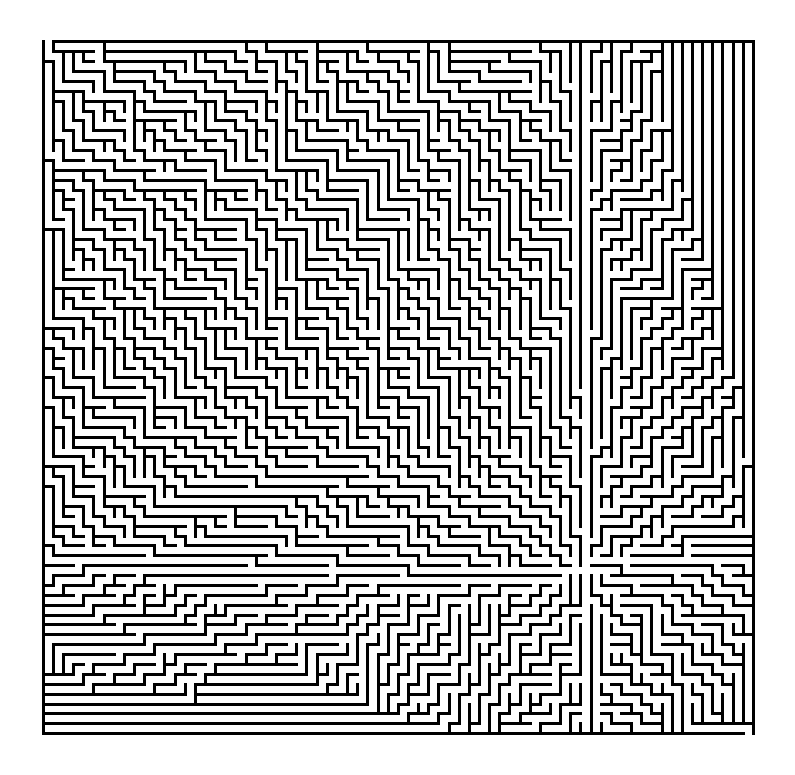

In [14]:
plot_maze(random_maze(70, 70, deque.popleft))

# `poprandom`

We can select a cell at random by shuffling the frontier before popping an element off of it.
This is an interesting compromise: it has some structure, but still works nicely as a maze, in my opinion.

In [16]:
def poprandom(seq):
    """Select and return a random element; remove it from the sequence."""
    element = random.choice(seq)
    seq.remove(element)
    return element

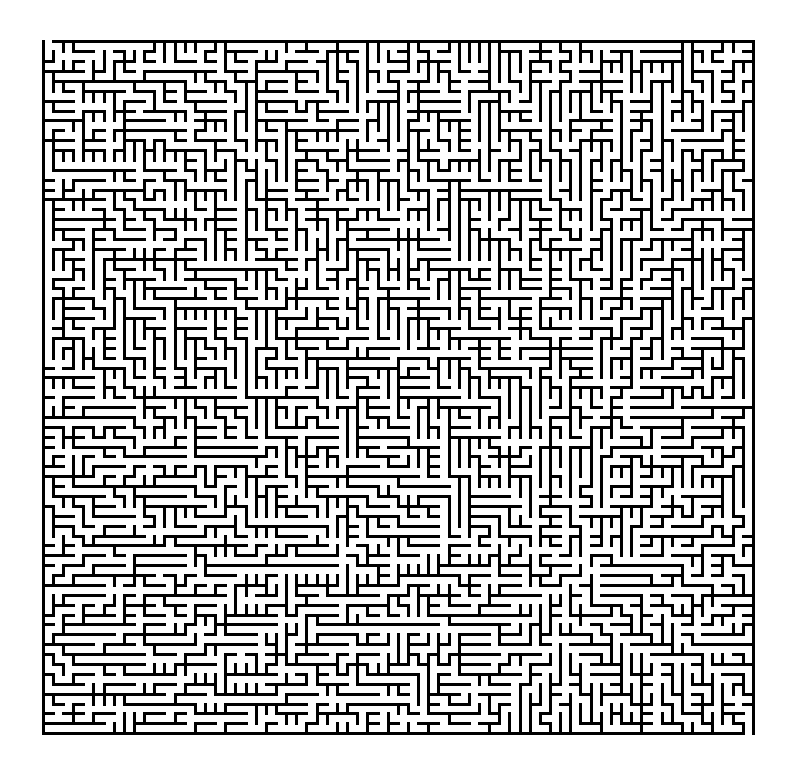

In [17]:
plot_maze(random_maze(70, 70, poprandom))

What other variations can you come up with to generate interesting mazes?